[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/box_sensitivities.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/deJong_Mackay_et_al_2023/box_sensitivities.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/box_sensitivities.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot
import matplotlib
from PySDM_examples.deJong_Azimi import Settings0D
from PySDM_examples.deJong_Azimi import run_box
from open_atmos_jupyter_utils import show_plot
import numpy as np
from PySDM.physics import si
from scipy.special import gamma

In [74]:
def dvdlnr_gamma(m, N, k, theta):
    return N * m**(k-1) * np.exp(-m / theta) / theta**k / gamma(k) * 3 * m**2 * 10

# Golovin Kernel

In [75]:
# MOM data
t = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0])
aM0 = np.array([100.0, 60.41666666666108, 36.50173611110569, 22.05313223379227, 13.32376739124922, 8.049776132212969, 4.863406413211965, 2.938308041315548, 1.775227774961471, 1.072533447372555, 0.6479889577875856, 0.39149332866333514, 0.23652721940076313])
aM1 = np.array([10.0, 10.0, 10.0, 10.000000000000002, 10.000000000000002, 9.999999999999991, 10.000000000000007, 10.000000000000002, 9.999999999999956, 9.999999999999966, 9.999999999999872, 10.000000000000062, 10.000000000000108])
aM2 = np.array([2.0, 5.333333333333704, 14.222222222223586, 37.92592592592996, 101.13580246914695, 269.69547325105935, 719.1879286694924, 1917.8344764519795, 5114.225270538599, 13637.934054769523, 36367.82414605215, 96980.86438947004, 258615.63837192673])
aDists = np.array([[10.0, 0.1, 1.0],[4.863406413211965, 69.86262088575636, 0.029431646782264554],[0.2365272194007631, 25819.285405029976, 0.0016374749145528168]])

In [76]:
25819.285405029976 ** 0.0016374749145528168

1.016774036683866

/var/folders/_6/ychcj4sn5k7cygz_qf48c5680000gn/T/ipykernel_32978/2899088862.py:2: RuntimeWarning: overflow encountered in power
  return N * m**(k-1) * np.exp(-m / theta) / theta**k / gamma(k) * 3 * m**2 * 10
/var/folders/_6/ychcj4sn5k7cygz_qf48c5680000gn/T/ipykernel_32978/2899088862.py:2: RuntimeWarning: invalid value encountered in multiply
  return N * m**(k-1) * np.exp(-m / theta) / theta**k / gamma(k) * 3 * m**2 * 10
/var/folders/_6/ychcj4sn5k7cygz_qf48c5680000gn/T/ipykernel_32978/2899088862.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return N * m**(k-1) * np.exp(-m / theta) / theta**k / gamma(k) * 3 * m**2 * 10
/var/folders/_6/ychcj4sn5k7cygz_qf48c5680000gn/T/ipykernel_32978/2899088862.py:2: RuntimeWarning: invalid value encountered in true_divide
  return N * m**(k-1) * np.exp(-m / theta) / theta**k / gamma(k) * 3 * m**2 * 10


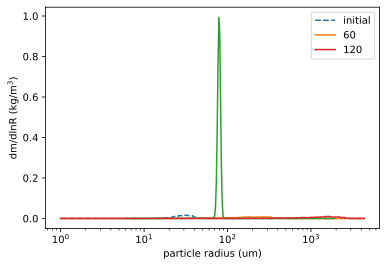

HTML(value="<a href='./box1.pdf' target='_blank'>./box1.pdf</a><br>")

In [77]:
settings = Settings0D()
settings._steps = [0, 60, 120]  # pylint: disable=protected-access

cmap = matplotlib.cm.get_cmap('viridis')

res = run_box(settings, settings._steps)

fig, ax = pyplot.subplots(ncols=1,sharey=True,figsize=(6,4),dpi=200)
ax.step(res.x, res.y[0]*settings.rho, linestyle='--', label='initial')

m_plt = np.logspace(-3.0, 6.0, 300) #µg
r_plt = (m_plt * 1e6 * 3 / 4 / np.pi) ** (1/3) #µm

for (j, step) in enumerate(settings._steps):  # pylint: disable=protected-access
    if j == 0:
        continue
    lbl = str(step)
    ax.step(res.x, res.y[j]*settings.rho, label=lbl)

    a_dmdlnr = dvdlnr_gamma(m_plt, aDists[j][0], aDists[j][1], aDists[j][2])
    ax.plot(r_plt, a_dmdlnr*1e-3)

ax.set_xscale("log")
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dlnR (kg/m$^3$)")
ax.legend()
show_plot('box1.pdf')

In [65]:
res.moments / settings.dv * si.cm**3

array([[9.99980210e+01, 9.99875871e-12, 1.99843119e-24],
       [4.92872900e+00, 9.99875871e-12, 7.82145450e-22],
       [2.31335000e-01, 9.99875871e-12, 2.35339401e-19]])

In [17]:
res.x

array([1.00000000e+00, 1.14475832e+00, 1.31047162e+00, 1.50017329e+00,
       1.71733586e+00, 1.96593452e+00, 2.25051990e+00, 2.57630139e+00,
       2.94924245e+00, 3.37616984e+00, 3.86489853e+00, 4.42437475e+00,
       5.06483982e+00, 5.79801754e+00, 6.63732883e+00, 7.59813742e+00,
       8.69803105e+00, 9.95714343e+00, 1.13985228e+01, 1.30485539e+01,
       1.49374406e+01, 1.70997595e+01, 1.95750920e+01, 2.24087494e+01,
       2.56526024e+01, 2.93660301e+01, 3.36170074e+01, 3.84833490e+01,
       4.40541340e+01, 5.04313366e+01, 5.77316922e+01, 6.60888352e+01,
       7.56557441e+01, 8.66075427e+01, 9.91447053e+01, 1.13496727e+02,
       1.29926322e+02, 1.48734239e+02, 1.70264758e+02, 1.94911998e+02,
       2.23127132e+02, 2.55426642e+02, 2.92401774e+02, 3.34729364e+02,
       3.83184225e+02, 4.38653331e+02, 5.02152051e+02, 5.74842740e+02,
       6.58056011e+02, 7.53315095e+02, 8.62363725e+02, 9.87198051e+02,
       1.13010318e+03, 1.29369503e+03, 1.48096815e+03, 1.69535061e+03,
      

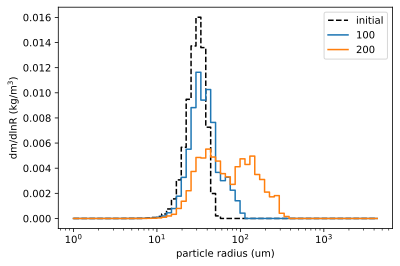

HTML(value="<a href='./box2.pdf' target='_blank'>./box2.pdf</a><br>")

In [22]:
from PySDM.dynamics.collisions.collision_kernels import SimpleGeometric
settings = Settings0D()
settings.kernel = SimpleGeometric(C=1e6 * np.pi)
settings.n_sd = 2**12
settings._steps = [0, 100, 200]  # pylint: disable=protected-access

cmap = matplotlib.cm.get_cmap('viridis')

res = run_box(settings, settings._steps)

fig, ax = pyplot.subplots(ncols=1,sharey=True,figsize=(6,4),dpi=200)
ax.step(res.x, res.y[0]*settings.rho, color='k', linestyle='--', label='initial')

for (j, step) in enumerate(settings._steps):  # pylint: disable=protected-access
    if j == 0:
        continue
    lbl = str(step)
    ax.step(res.x, res.y[j]*settings.rho, label=lbl)

ax.set_xscale("log")
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dlnR (kg/m$^3$)")
ax.legend()
show_plot('box2.pdf')